In [130]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [131]:

import os
import numpy as np
import pandas as pd
from pathlib import Path
import yaml

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

os.chdir(Path(os.getcwd()).parent)
from assistive_arm.utils.data_preprocessing import prepare_opencap_markers
from assistive_arm.utils.optimum_length_utils import compute_torque_profiles, get_rotation_matrix

## Read data

### Marker data

In [132]:
subject = "subject_1"
subject_data = Path("/Users/xabieririzar/Desktop/Life/Studium/TUM/M.Sc Robotics/Harvard/Thesis/Subject testing/Subject data/") / subject
trial = subject_data / "trial_2"

project_moco_data = Path("/Users/xabieririzar/uni-projects/Harvard/assistive-arm/moco/")
control_solutions = project_moco_data / "control_solutions"

# Set directories
opencap_markers = pd.read_csv(trial / "opencap_tracker.trc", delimiter="\t", skiprows=3).tail(-1)
filtered_markers = prepare_opencap_markers(opencap_markers)

# Read solution and yaml config
solution_path = control_solutions / "opencap_simple_assistance_false_2023-09-22_17-13.sto"
control_solution = pd.read_csv(solution_path, delimiter="\t", skiprows=18)
config_path = control_solutions / f"{solution_path.stem}.yaml"

try:
    with open(config_path, "r") as f:
        config_file = yaml.load(f, Loader=yaml.FullLoader)
except FileNotFoundError:
    print(f"No config file found at {config_path}")


No config file found at /Users/xabieririzar/uni-projects/Harvard/assistive-arm/moco/control_solutions/opencap_simple_assistance_false_2023-09-22_17-13.yaml


### Get pelvis marker and set it as human anchoring position

In [133]:
pelvis_x = (filtered_markers["r.PSIS_study"].X + filtered_markers["L.PSIS_study"].X)/2 
pelvis_y = (filtered_markers["r.PSIS_study"].Y + filtered_markers["L.PSIS_study"].Y)/2 
pelvis_z = (filtered_markers["r.PSIS_study"].Z + filtered_markers["L.PSIS_study"].Z)/2 

pelvis_marker = pd.DataFrame({"Time": filtered_markers.Time.t, "X": pelvis_x, "Y": pelvis_y, "Z": pelvis_z})
pelvis_marker = pelvis_marker[(pelvis_marker.Time >= 1.8) & (pelvis_marker.Time <= 3.2)].reset_index(drop=True)
pelvis_marker.set_index("Time", inplace=True)
new_index = pd.Index(np.arange(pelvis_marker.index.min(), pelvis_marker.index.max() + 0.025, step=0.025), name="Time")
pelvis_marker_aligned = pelvis_marker.reindex(new_index, method="nearest")


### Read assistive force profile

In [134]:
assistive_force = control_solution[["time", "/forceset/reserve_jointset_ground_pelvis_pelvis_tx", "/forceset/reserve_jointset_ground_pelvis_pelvis_ty"]]
assistive_force.set_index("time", inplace=True)
assistive_force.columns = ["X", "Y"]
assistive_force.insert(2, "Z", 0)
assistive_force *= 100
assistive_force *= 0.6666

## Calculate optimal link length ratio

### Get distance vector from pelvis to anchor point

In [135]:
chair_position = np.array([-0.6, 0.5, -0.075])
pelvis_to_chair = chair_position - pelvis_marker_aligned

print(f"Anchoring point on bench: {pelvis_to_chair.X.iloc[0]}m away from pelvis")

Anchoring point on bench: -0.24704335m away from pelvis


### Calculate optimal length

In [136]:
min_necessary_length = np.linalg.norm(pelvis_to_chair, axis=1).max()

print("Minimum total length: ", min_necessary_length)

resolution = 30

link_lengths_1 = np.linspace(0.1, 1, resolution)
link_lengths_2 = np.linspace(0.1, 1, resolution)
link_lengths_1 = link_lengths_1[link_lengths_1 < min_necessary_length]
link_lengths_2 = link_lengths_2[link_lengths_2 < min_necessary_length]

# Set joint angle limits (degrees)
theta_1_lims = np.deg2rad([0, 180])
theta_2_lims = np.deg2rad([-145, 145])

results = []

for l1 in link_lengths_1:
    for l2 in link_lengths_2:
        if l1 + l2 < min_necessary_length:
            continue
               
        torques, joint_angles = compute_torque_profiles(l1, l2, F=assistive_force, position=pelvis_to_chair)

        if np.any(np.isnan(torques)) or np.any(np.isnan(joint_angles)):
            continue
        result = {
            'l1': l1,
            'l2': l2,
            'tau_1': torques[:, 0],
            'tau_2': torques[:, 1],
            'theta_1': joint_angles.theta_1,
            'theta_2': joint_angles.theta_2,
        }
        results.append(result)

Minimum total length:  0.8402363059070971


In [137]:
link_length_torque_profiles = pd.DataFrame(results)
link_length_torque_profiles.dropna(inplace=True)

In [138]:
# Filter out solutions that are outside of the joint angle limits
def check_theta(series, theta_lims):
    return series.apply(lambda x: theta_lims[0] <= x <= theta_lims[1]).all()

link_length_torque_profiles = link_length_torque_profiles[link_length_torque_profiles["theta_1"].apply(check_theta, theta_lims=theta_2_lims) & link_length_torque_profiles["theta_2"].apply(check_theta, theta_lims=theta_2_lims)]

In [139]:
link_length_torque_profiles

,l1,l2,tau_1,tau_2,theta_1,theta_2
12,0.410345,0.441379,"[1.3529134657538249, -10.95632739815789, -22.7...","[1.1939362659220396, -4.895721211989825, -10.3...",Time 1.800 0.608432 1.825 0.598828 1.850...,Time 1.800 2.504841 1.825 2.507230 1.850...
20,0.441379,0.410345,"[1.3529134657538244, -10.956327398157889, -22....","[0.9454205605891531, -2.868694002167842, -6.00...",Time 1.800 0.828646 1.825 0.819922 1.850...,Time 1.800 2.504841 1.825 2.507230 1.850...


In [140]:
# Get ideal torque combination
peak_torques = link_length_torque_profiles[["tau_1", "tau_2"]].map(lambda x: np.abs(x).max())
min_overall_torque = np.linalg.norm(peak_torques, axis=1)
min_torque_loc = min_overall_torque.argmin()
ideal_torque = peak_torques.iloc[min_torque_loc]

In [141]:
l1, l2, tau_1, tau_2, theta_1, theta_2 = link_length_torque_profiles.iloc[min_torque_loc]

In [142]:
# Calculate ideal bar length based on offset from rotational axis and link inserts
bar_1 = l1 - 0.103
bar_2 = l2 - 0.081125
print(f"Bar 1: {bar_1:.3f} m")
print(f"Bar 2: {bar_2:.3f} m")

Bar 1: 0.338 m
Bar 2: 0.329 m


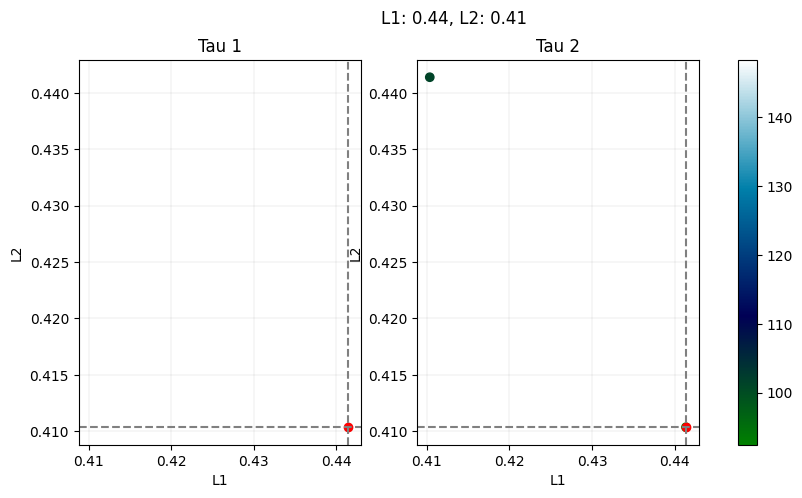

In [143]:
cNorm  = colors.Normalize(vmin=np.min([peak_torques.tau_1.min(), peak_torques.tau_2.min()]), vmax=np.max([peak_torques.tau_1.max(), peak_torques.tau_2.max()]))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap="ocean")

highlight = (l1, l2)
highlight_label = f"({l1:.2f}, {l2:.2f})"

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(f"L1: {l1:.2f}, L2: {l2:.2f}")

sc1 = axs[0].scatter(link_length_torque_profiles.l1, link_length_torque_profiles.l2, c=scalarMap.to_rgba(peak_torques.tau_1))
axs[0].scatter(*highlight, color='red')
axs[0].axvline(x=highlight[0], linestyle="--", color='grey')  # adding vertical line
axs[0].axhline(y=highlight[1], linestyle="--", color='grey')
axs[0].grid(color='black', linestyle='-', linewidth=0.1, alpha=0.5)
axs[0].set_xlabel("L1")
axs[0].set_ylabel("L2")
axs[0].set_title("Tau 1")


sc2 = axs[1].scatter(link_length_torque_profiles.l1, link_length_torque_profiles.l2, c=scalarMap.to_rgba(peak_torques.tau_2))
axs[1].scatter(*highlight, color='red')
axs[1].axvline(x=highlight[0], linestyle="--", color='grey')  # adding vertical line
axs[1].axhline(y=highlight[1], linestyle="--", color='grey')
axs[1].grid(color='black', linestyle='-', linewidth=0.1, alpha=0.5)
axs[1].set_xlabel("L1")
axs[1].set_ylabel("L2")
axs[1].set_title("Tau 2")

fig.colorbar(scalarMap, ax=axs.ravel().tolist())

plt.show()

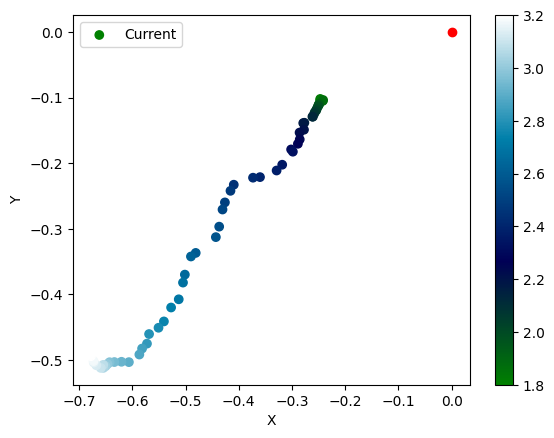

In [144]:
rotate_90 = get_rotation_matrix(90)

P_EE = np.array([l1*np.cos(theta_1) + l2*np.cos(theta_1 + theta_2), l1*np.sin(theta_1) + l2*np.sin(theta_1 + theta_2), np.zeros(theta_1.shape)])
P_L1 = np.array([l1*np.cos(theta_1), l1*np.sin(theta_1), np.zeros(theta_1.shape)])

plt.scatter((rotate_90 @ P_EE)[0], (rotate_90 @ P_EE)[1], c=pelvis_to_chair.index, cmap="ocean", label="Current")
plt.colorbar()
plt.plot(0, 0, "o", c="r")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

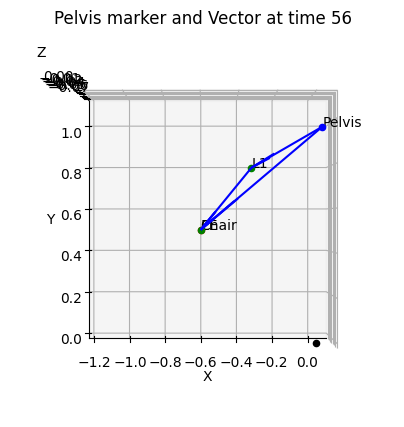

In [145]:
rotate_90 = get_rotation_matrix(90)

timestep = 56
plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')
ax.view_init(azim=-90, elev=90)

pelvis_pos = pelvis_marker_aligned.iloc[timestep]
pelvis_chair = pelvis_to_chair.iloc[timestep].T

l1_vector = rotate_90 @ P_L1.T[timestep, :]
l1_origin = pelvis_pos
l1_pos = pelvis_pos + l1_vector

l2_pos = rotate_90 @ P_EE.T[timestep, :]
l2_origin = l1_pos
l2_vector = l2_pos - l1_vector

ee_pos = pelvis_pos + l2_pos

ax.scatter(*pelvis_pos, color="b")
ax.text(*pelvis_pos, "Pelvis")

ax.scatter(*l1_pos, color="g")
ax.text(*l1_pos, "L1")

ax.scatter(*ee_pos, color="g")
ax.text(*ee_pos, "EE")

ax.scatter(*chair_position, color="r")
ax.text(*chair_position, "Chair")

origin = [0, 0, 0]
ax.scatter(*origin, color="k")

ax.quiver(*pelvis_pos, *pelvis_chair, color="b")
ax.quiver(*l1_origin, *l1_vector, color="b")
ax.quiver(*l2_origin, *l2_vector, color="b")
ax.set_xlim([-1.2, pelvis_marker_aligned.X.max()])
ax.set_ylim([0, 1.1])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Pelvis marker and Vector at time {}'.format(timestep))

plt.show()

In [146]:
# Rad/s to rpm
time_vector = assistive_force.index
theta_1_dot = np.gradient(theta_1) / time_vector.diff()
theta_2_dot = np.gradient(theta_2) / time_vector.diff()

<Axes: xlabel='Time'>

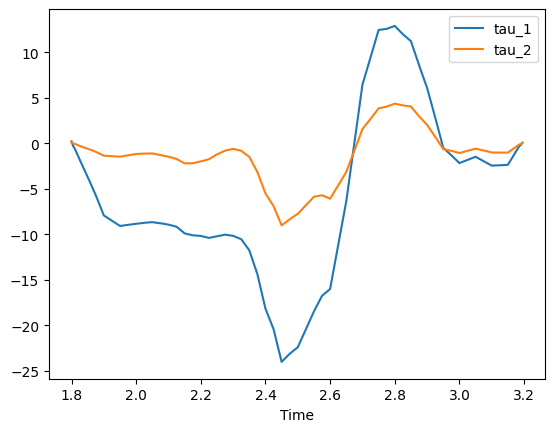

In [151]:
torque_profile = pd.DataFrame({"tau_1": tau_1, 'tau_2': tau_2}, index=time_vector)

def interpolate_dataframe(df, desired_frequency):
    time_vector = df.index
    time_vector_new = pd.Index(np.arange(time_vector.min(), time_vector.max(), 1/desired_frequency), name="Time")
    df_interpolated = df.reindex(time_vector_new, method="nearest").interpolate(method="polynomial", order=2)

    return df_interpolated

def smooth_dataframe(df, window_size):
    df_smoothed = df.rolling(window=window_size, min_periods=1, center=True).mean()
    return df_smoothed

# Apply the smoothing function with a chosen window size
window_size = 5  # The window size can be adjusted based on how smooth you want the data to be
smoothed_torque_profile = smooth_dataframe(interpolate_dataframe(torque_profile, 200), window_size)

# Define maximum absolute values for tau1 and tau2
max_tau1 = 24
max_tau2 = 9

# Scale the torque profiles
scale_factor_tau1 = max_tau1 / np.abs(smoothed_torque_profile['tau_1']).max()
scale_factor_tau2 = max_tau2 / np.abs(smoothed_torque_profile['tau_2']).max()

scaled_torque_profile = smoothed_torque_profile.copy()
scaled_torque_profile['tau_1'] *= scale_factor_tau1
scaled_torque_profile['tau_2'] *= scale_factor_tau2

# Plot the scaled data
scaled_torque_profile.plot()



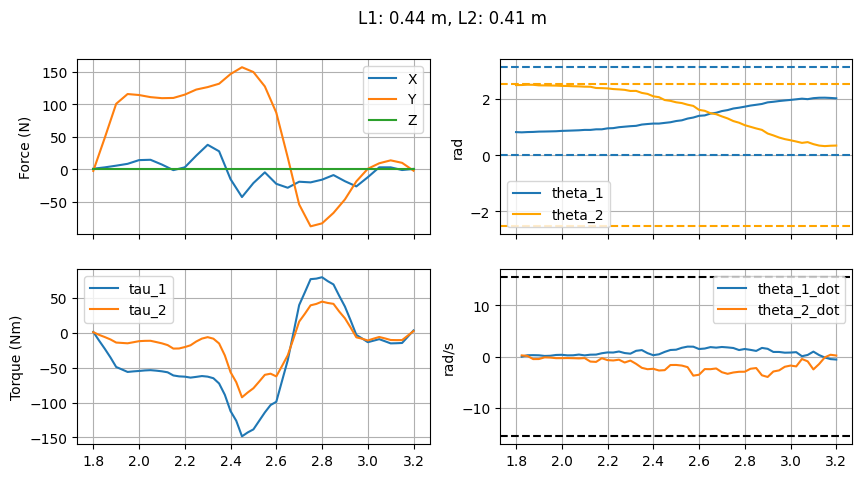

In [148]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5), sharex=True)
fig.suptitle(f"L1: {float(l1):.2f} m, L2: {float(l2):.2f} m")
axs[0, 0].plot(time_vector, assistive_force)
axs[0, 0].set_ylabel("Force (N)")
axs[0, 0].legend(["X", "Y", "Z"])
axs[0, 0].grid()

axs[1, 0].plot(time_vector, tau_1, label="tau_1")
axs[1, 0].plot(time_vector, tau_2, label="tau_2")
axs[1, 0].legend()
axs[1, 0].set_ylabel("Torque (Nm)")
axs[1, 0].grid()

axs[0, 1].plot(time_vector, theta_1, label="theta_1", color="C0")
axs[0, 1].axhline(y=theta_1_lims[0], linestyle="--", color="C0")
axs[0, 1].axhline(y=theta_1_lims[1], linestyle="--", color="C0")
axs[0, 1].plot(time_vector, theta_2, label="theta_2", color="orange")
axs[0, 1].axhline(y=theta_2_lims[0], linestyle="--", color="orange")
axs[0, 1].axhline(y=theta_2_lims[1], linestyle="--", color="orange")
axs[0, 1].legend()
axs[0, 1].set_ylabel("rad")
axs[0, 1].grid()

# Add dashed line for max rad/s with label
axs[1, 1].plot(time_vector, theta_1_dot, label="theta_1_dot")
axs[1, 1].plot(time_vector, theta_2_dot, label="theta_2_dot")
axs[1, 1].axhline(y=15.5, linestyle="--", color="k")
axs[1, 1].axhline(y=-15.5, linestyle="--", color="k")
axs[1, 1].legend()
axs[1, 1].set_ylabel("rad/s")
axs[1, 1].grid()